# T1/T2 MRI CycleGAN s U-Net Generatorima

Ova bilježnica implementira CycleGAN model za transformaciju između T1 i T2 MRI snimaka. Koristi U-Net arhitekturu za generatore kako bi se postigli bolji rezultati u očuvanju strukture.

In [1]:
!nvidia-smi


Thu May  8 19:41:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   38C    P5             19W /   80W |     599MiB /   6144MiB |     34%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Postavljanje okruženja i uvoz bibliteka

In [1]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import torch.backends.cudnn as cudnn
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
import datetime
import json

# Postavljanje random seed-a za reproducibilnost
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    # Omogućavanje CUDNN benchmarkinga za brže treniranje
    cudnn.benchmark = True
# Provjera dostupnosti GPU-a
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Koristim uređaj: {device}")
# Ako je dostupan CUDA, ispiši informacije o GPU-u
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memorija: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


Koristim uređaj: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Memorija: 6.19 GB


In [11]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from utils.models import UNetGeneratorDeep
from utils.config import CycleGANConfig
from utils.dataset import get_stratified_data_loaders
from utils.train import train_cyclegan
from utils.test import test_model
from utils.visualization import visualize_results, plot_training_curves


In [ ]:
config = CycleGANConfig(
    t1_dir="../dataset/data/images/t1",  # Prilagodite putanju prema vašim podacima
    t2_dir="../dataset/data/images/t2",  # Prilagodite putanju prema vašim podacima
    results_dir="../rezultati/deep_model",
    checkpoints_dir="../checkpoints/deep_model",
    batch_size=4,  # Smanjite za manje GPU memorije
    lr=0.0002,
    beta1=0.5,
    beta2=0.999,
    n_epochs=150,  # Prilagodite broj epoha prema potrebi
    decay_epoch=50,  # Learning rate počinje opadati nakon ove epohe
    img_size=256,
    input_channels=1,  # MRI slike su sive (1 kanal)
    output_channels=1,
    ngf=64,  # Broj filtera u generatoru
    ndf=64,  # Broj filtera u diskriminatoru
    lambda_A=10.0,  # Težina cycle loss-a za T1->T2->T1
    lambda_B=10.0,  # Težina cycle loss-a za T2->T1->T2
    lambda_identity=0.5,  # Težina identity loss-a
    architecture="deep",  # Koristimo standardnu arhitekturu
    sample_interval=50,  # Vizualiziraj slike svakih 5 epoha
    checkpoint_interval=50,  # Spremi checkpoint svakih 10 epoha
    device=None  # Automatski odabir (GPU ako je dostupan, inače CPU)
)

In [5]:
# Ispiši konfiguraciju
config.print_config()


=== Konfiguracija modela ===
Arhitektura: deep
T1 direktorij: ../dataset/data/images/t1
T2 direktorij: ../dataset/data/images/t2
Batch veličina: 4
Learning rate: 0.0002
Broj epoha: 150
Veličina slike: 256x256
Broj filtera u generatoru: 64
Broj filtera u diskriminatoru: 64
Lambda A: 10.0
Lambda B: 10.0
Lambda identity: 0.5
Uređaj: cuda



In [6]:
# Lista posebnih ID-ova za stratificiranu podjelu (ID-ovi "mutnijih" slika)
special_ids = [
    '035', '230', '231', '232', '233', '234', '238', '290', '291', '292', 
    '293', '294', '303', '305', '306', '307', '310', '314', '315', '322', 
    '331', '332', '333', '337', '340', '345', '347', '371', '372', '373', 
    '378', '382', '388', '395', '423', '424', '425', '426', '427', '430', 
    '433', '434', '435', '442', '462', '463', '464', '469', '470', '473', 
    '474', '475', '476', '477', '478', '510', '517', '532', '541', '542', 
    '543', '547', '548', '553', '561', '563', '571', '573', '574', '588', 
    '595', '596', '597'
]

print(f"Broj posebnih ID-ova: {len(special_ids)}")

train_dataloader, val_dataloader, test_dataloader = get_stratified_data_loaders(
    config=config,
    special_ids=special_ids,
    train_ratio=0.8,
    val_ratio=0.05,
    test_ratio=0.15
)

Broj posebnih ID-ova: 73
Pronađeno 572 T1 slika i 572 T2 slika
Pronađeno 572 sparenih T1/T2 slika
Pronađeno 69 posebnih slika i 503 regularnih slika.
Podjela posebnih slika: 55 trening, 3 validacija, 11 test
Podjela regularnih slika: 402 trening, 25 validacija, 76 test
Ukupna podjela: 457 trening, 28 validacija, 87 test


In [7]:
G_AB, G_BA, train_history, best_val_loss = train_cyclegan(
    config=config,
    use_test_split=True,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader
)

Epoha 1/150: 100%|██████████| 115/115 [00:43<00:00,  2.64it/s, D_A_loss=1.3563, D_B_loss=1.1375, G_loss=13.8592]   


Epoha 1/150 - Train gubici: G: 25.9763, D_A: 4.4200, D_B: 3.6909 | Val gubici: G: 10.8720, Cycle: 6.9538
Novi najbolji validacijski gubitak: 6.9538, spremam modele...


Epoha 2/150: 100%|██████████| 115/115 [00:39<00:00,  2.88it/s, D_A_loss=0.8494, D_B_loss=0.1602, G_loss=7.8231] 


Epoha 2/150 - Train gubici: G: 10.0554, D_A: 0.4222, D_B: 0.9532 | Val gubici: G: 3.8867, Cycle: 2.9956
Novi najbolji validacijski gubitak: 2.9956, spremam modele...


Epoha 3/150: 100%|██████████| 115/115 [00:39<00:00,  2.95it/s, D_A_loss=0.5806, D_B_loss=0.0613, G_loss=5.8132]


Epoha 3/150 - Train gubici: G: 5.4511, D_A: 0.3001, D_B: 0.0612 | Val gubici: G: 2.6963, Cycle: 2.2384
Novi najbolji validacijski gubitak: 2.2384, spremam modele...


Epoha 4/150: 100%|██████████| 115/115 [00:39<00:00,  2.94it/s, D_A_loss=0.2139, D_B_loss=0.0630, G_loss=3.8048]


Epoha 4/150 - Train gubici: G: 4.4108, D_A: 0.2679, D_B: 0.3278 | Val gubici: G: 2.5971, Cycle: 1.7769
Novi najbolji validacijski gubitak: 1.7769, spremam modele...


Epoha 5/150: 100%|██████████| 115/115 [00:39<00:00,  2.94it/s, D_A_loss=0.2677, D_B_loss=0.1531, G_loss=3.3561]


Epoha 5/150 - Train gubici: G: 3.5733, D_A: 0.2793, D_B: 0.1998 | Val gubici: G: 2.7559, Cycle: 1.4825
Novi najbolji validacijski gubitak: 1.4825, spremam modele...


Epoha 6/150: 100%|██████████| 115/115 [00:39<00:00,  2.94it/s, D_A_loss=0.0922, D_B_loss=0.1279, G_loss=2.9928]


Epoha 6/150 - Train gubici: G: 3.2491, D_A: 0.2741, D_B: 0.2381 | Val gubici: G: 1.8189, Cycle: 1.6500


Epoha 7/150: 100%|██████████| 115/115 [00:39<00:00,  2.94it/s, D_A_loss=0.3024, D_B_loss=0.1727, G_loss=2.2369]


Epoha 7/150 - Train gubici: G: 2.9998, D_A: 0.2610, D_B: 0.2589 | Val gubici: G: 2.2353, Cycle: 1.2693
Novi najbolji validacijski gubitak: 1.2693, spremam modele...


Epoha 8/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.3686, D_B_loss=0.2445, G_loss=2.2663]


Epoha 8/150 - Train gubici: G: 2.8704, D_A: 0.2786, D_B: 0.2360 | Val gubici: G: 2.5957, Cycle: 1.5453


Epoha 9/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.5108, D_B_loss=0.0918, G_loss=4.2754]


Epoha 9/150 - Train gubici: G: 2.7483, D_A: 0.2522, D_B: 0.2404 | Val gubici: G: 1.5626, Cycle: 1.2324
Novi najbolji validacijski gubitak: 1.2324, spremam modele...


Epoha 10/150: 100%|██████████| 115/115 [00:42<00:00,  2.73it/s, D_A_loss=0.3645, D_B_loss=0.1579, G_loss=3.0858]


Epoha 10/150 - Train gubici: G: 2.6341, D_A: 0.2556, D_B: 0.2284 | Val gubici: G: 2.3665, Cycle: 1.4609


Epoha 11/150: 100%|██████████| 115/115 [00:41<00:00,  2.75it/s, D_A_loss=0.6046, D_B_loss=0.1346, G_loss=3.8477]


Epoha 11/150 - Train gubici: G: 2.6202, D_A: 0.2512, D_B: 0.2389 | Val gubici: G: 1.7513, Cycle: 1.2857


Epoha 12/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.1716, D_B_loss=0.0764, G_loss=2.7099]


Epoha 12/150 - Train gubici: G: 2.4983, D_A: 0.2415, D_B: 0.2166 | Val gubici: G: 1.3104, Cycle: 1.1725
Novi najbolji validacijski gubitak: 1.1725, spremam modele...


Epoha 13/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.2693, D_B_loss=0.1832, G_loss=1.8275]


Epoha 13/150 - Train gubici: G: 2.4352, D_A: 0.2229, D_B: 0.2084 | Val gubici: G: 3.3788, Cycle: 1.3619


Epoha 14/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0618, D_B_loss=0.2784, G_loss=2.1813]


Epoha 14/150 - Train gubici: G: 2.4437, D_A: 0.2294, D_B: 0.2217 | Val gubici: G: 1.2565, Cycle: 0.9729
Novi najbolji validacijski gubitak: 0.9729, spremam modele...


Epoha 15/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0859, D_B_loss=0.2710, G_loss=2.5503]


Epoha 15/150 - Train gubici: G: 2.3660, D_A: 0.2424, D_B: 0.1934 | Val gubici: G: 1.9927, Cycle: 1.0474


Epoha 16/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.3112, D_B_loss=0.1861, G_loss=2.1081]


Epoha 16/150 - Train gubici: G: 2.3582, D_A: 0.2356, D_B: 0.2085 | Val gubici: G: 1.3747, Cycle: 1.0507


Epoha 17/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.3468, D_B_loss=0.3823, G_loss=2.2920]


Epoha 17/150 - Train gubici: G: 2.3023, D_A: 0.2355, D_B: 0.1858 | Val gubici: G: 3.1272, Cycle: 0.9819


Epoha 18/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0663, D_B_loss=0.1154, G_loss=2.0898]


Epoha 18/150 - Train gubici: G: 2.2925, D_A: 0.2201, D_B: 0.1948 | Val gubici: G: 1.4625, Cycle: 0.9962


Epoha 19/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.1989, D_B_loss=0.2238, G_loss=2.0784]


Epoha 19/150 - Train gubici: G: 2.3120, D_A: 0.2458, D_B: 0.2039 | Val gubici: G: 1.8692, Cycle: 0.9396
Novi najbolji validacijski gubitak: 0.9396, spremam modele...


Epoha 20/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0712, D_B_loss=0.1011, G_loss=1.9867]


Epoha 20/150 - Train gubici: G: 2.2649, D_A: 0.2367, D_B: 0.1710 | Val gubici: G: 1.9458, Cycle: 0.9133
Novi najbolji validacijski gubitak: 0.9133, spremam modele...


Epoha 21/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.1887, D_B_loss=0.1119, G_loss=1.9081]


Epoha 21/150 - Train gubici: G: 2.2464, D_A: 0.2081, D_B: 0.1931 | Val gubici: G: 1.6031, Cycle: 0.9788


Epoha 22/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.1235, D_B_loss=0.1425, G_loss=1.9581]


Epoha 22/150 - Train gubici: G: 2.2879, D_A: 0.2176, D_B: 0.1981 | Val gubici: G: 1.3963, Cycle: 0.8903
Novi najbolji validacijski gubitak: 0.8903, spremam modele...


Epoha 23/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0991, D_B_loss=0.0258, G_loss=2.1735]


Epoha 23/150 - Train gubici: G: 2.2108, D_A: 0.2137, D_B: 0.1659 | Val gubici: G: 2.5267, Cycle: 0.9057


Epoha 24/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.1097, D_B_loss=0.2522, G_loss=1.7229]


Epoha 24/150 - Train gubici: G: 2.2469, D_A: 0.2158, D_B: 0.1693 | Val gubici: G: 2.2244, Cycle: 0.8855
Novi najbolji validacijski gubitak: 0.8855, spremam modele...


Epoha 25/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.2440, D_B_loss=0.1155, G_loss=2.2027]


Epoha 25/150 - Train gubici: G: 2.1962, D_A: 0.2102, D_B: 0.1730 | Val gubici: G: 1.5610, Cycle: 1.0522


Epoha 26/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.1605, D_B_loss=0.0888, G_loss=2.2218]


Epoha 26/150 - Train gubici: G: 2.2010, D_A: 0.2135, D_B: 0.1673 | Val gubici: G: 1.3270, Cycle: 0.8753
Novi najbolji validacijski gubitak: 0.8753, spremam modele...


Epoha 27/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.1391, D_B_loss=0.1019, G_loss=2.6473]


Epoha 27/150 - Train gubici: G: 2.1718, D_A: 0.2042, D_B: 0.1655 | Val gubici: G: 1.6178, Cycle: 1.0322


Epoha 28/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.3249, D_B_loss=0.0544, G_loss=1.2873]


Epoha 28/150 - Train gubici: G: 2.1913, D_A: 0.2191, D_B: 0.1609 | Val gubici: G: 2.1918, Cycle: 0.8527
Novi najbolji validacijski gubitak: 0.8527, spremam modele...


Epoha 29/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0494, D_B_loss=0.1515, G_loss=1.7373]


Epoha 29/150 - Train gubici: G: 2.1430, D_A: 0.1955, D_B: 0.1611 | Val gubici: G: 1.3300, Cycle: 0.9175


Epoha 30/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0480, D_B_loss=0.0952, G_loss=1.9679]


Epoha 30/150 - Train gubici: G: 2.1317, D_A: 0.1875, D_B: 0.1614 | Val gubici: G: 2.2607, Cycle: 1.0276


Epoha 31/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0612, D_B_loss=0.1576, G_loss=1.6412]


Epoha 31/150 - Train gubici: G: 2.1894, D_A: 0.1853, D_B: 0.1550 | Val gubici: G: 1.3460, Cycle: 0.8947


Epoha 32/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0691, D_B_loss=0.0805, G_loss=1.4790]


Epoha 32/150 - Train gubici: G: 2.1648, D_A: 0.2016, D_B: 0.1541 | Val gubici: G: 1.5704, Cycle: 1.0529


Epoha 33/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.2101, D_B_loss=0.1328, G_loss=2.1245]


Epoha 33/150 - Train gubici: G: 2.1578, D_A: 0.1741, D_B: 0.1610 | Val gubici: G: 2.0213, Cycle: 1.1540


Epoha 34/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.1312, D_B_loss=0.0485, G_loss=2.2799]


Epoha 34/150 - Train gubici: G: 2.1717, D_A: 0.1882, D_B: 0.1599 | Val gubici: G: 1.3803, Cycle: 0.9085


Epoha 35/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.1132, D_B_loss=0.1054, G_loss=2.4895]


Epoha 35/150 - Train gubici: G: 2.1423, D_A: 0.1649, D_B: 0.1235 | Val gubici: G: 2.7524, Cycle: 1.0146


Epoha 36/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.2241, D_B_loss=0.2401, G_loss=2.0248]


Epoha 36/150 - Train gubici: G: 2.1935, D_A: 0.1961, D_B: 0.1483 | Val gubici: G: 2.5558, Cycle: 1.0401


Epoha 37/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.1154, D_B_loss=0.0149, G_loss=2.4756]


Epoha 37/150 - Train gubici: G: 2.1987, D_A: 0.1901, D_B: 0.1426 | Val gubici: G: 2.2467, Cycle: 0.9705


Epoha 38/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.1586, D_B_loss=0.1491, G_loss=2.9321]


Epoha 38/150 - Train gubici: G: 2.1561, D_A: 0.1685, D_B: 0.1406 | Val gubici: G: 2.8488, Cycle: 1.1935


Epoha 39/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.2695, D_B_loss=0.2641, G_loss=1.4155]


Epoha 39/150 - Train gubici: G: 2.1811, D_A: 0.1820, D_B: 0.1275 | Val gubici: G: 3.7735, Cycle: 0.8849


Epoha 40/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0972, D_B_loss=0.0214, G_loss=1.4452]


Epoha 40/150 - Train gubici: G: 2.2151, D_A: 0.1854, D_B: 0.1368 | Val gubici: G: 1.3583, Cycle: 1.0095


Epoha 41/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.2045, D_B_loss=0.2902, G_loss=2.9381]


Epoha 41/150 - Train gubici: G: 2.1293, D_A: 0.2100, D_B: 0.1358 | Val gubici: G: 1.3408, Cycle: 1.1254


Epoha 42/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0942, D_B_loss=0.0619, G_loss=1.6766]


Epoha 42/150 - Train gubici: G: 2.1085, D_A: 0.1667, D_B: 0.1351 | Val gubici: G: 2.0773, Cycle: 0.8979


Epoha 43/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0434, D_B_loss=0.0582, G_loss=2.0622]


Epoha 43/150 - Train gubici: G: 2.1424, D_A: 0.1614, D_B: 0.1238 | Val gubici: G: 1.1501, Cycle: 0.8781


Epoha 44/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0733, D_B_loss=0.0868, G_loss=1.5772]


Epoha 44/150 - Train gubici: G: 2.1538, D_A: 0.1400, D_B: 0.1071 | Val gubici: G: 1.4144, Cycle: 1.0121


Epoha 45/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0811, D_B_loss=0.0755, G_loss=2.2041]


Epoha 45/150 - Train gubici: G: 2.1761, D_A: 0.1656, D_B: 0.1398 | Val gubici: G: 1.6959, Cycle: 0.8949


Epoha 46/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0841, D_B_loss=0.0478, G_loss=1.7580]


Epoha 46/150 - Train gubici: G: 2.1745, D_A: 0.1812, D_B: 0.1298 | Val gubici: G: 2.1950, Cycle: 0.8870


Epoha 47/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.1760, D_B_loss=0.1437, G_loss=2.0629]


Epoha 47/150 - Train gubici: G: 2.1974, D_A: 0.1721, D_B: 0.1309 | Val gubici: G: 1.4899, Cycle: 0.9726


Epoha 48/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0547, D_B_loss=0.1689, G_loss=2.2992]


Epoha 48/150 - Train gubici: G: 2.1610, D_A: 0.1530, D_B: 0.1373 | Val gubici: G: 2.4437, Cycle: 0.9688


Epoha 49/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0322, D_B_loss=0.0476, G_loss=2.1663]


Epoha 49/150 - Train gubici: G: 2.2952, D_A: 0.1636, D_B: 0.1144 | Val gubici: G: 2.3892, Cycle: 0.9312


Epoha 50/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.1050, D_B_loss=0.1283, G_loss=2.4325]


Epoha 50/150 - Train gubici: G: 2.3709, D_A: 0.1290, D_B: 0.0999 | Val gubici: G: 1.9881, Cycle: 0.8764


Epoha 51/150: 100%|██████████| 115/115 [00:40<00:00,  2.82it/s, D_A_loss=0.0176, D_B_loss=0.0840, G_loss=2.3314]


Epoha 51/150 - Train gubici: G: 2.1816, D_A: 0.1592, D_B: 0.1207 | Val gubici: G: 1.9140, Cycle: 0.9721


Epoha 52/150: 100%|██████████| 115/115 [00:42<00:00,  2.68it/s, D_A_loss=0.1084, D_B_loss=0.0708, G_loss=1.5438]


Epoha 52/150 - Train gubici: G: 2.2230, D_A: 0.1489, D_B: 0.1252 | Val gubici: G: 2.2386, Cycle: 1.0219


Epoha 53/150: 100%|██████████| 115/115 [00:40<00:00,  2.82it/s, D_A_loss=0.1996, D_B_loss=0.1952, G_loss=3.6607]


Epoha 53/150 - Train gubici: G: 2.2650, D_A: 0.1605, D_B: 0.1089 | Val gubici: G: 1.3118, Cycle: 0.8923


Epoha 54/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0497, D_B_loss=0.0899, G_loss=1.8917]


Epoha 54/150 - Train gubici: G: 2.2434, D_A: 0.1218, D_B: 0.1057 | Val gubici: G: 1.1250, Cycle: 0.9107


Epoha 55/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.1365, D_B_loss=0.0718, G_loss=2.9476]


Epoha 55/150 - Train gubici: G: 2.2439, D_A: 0.1332, D_B: 0.1030 | Val gubici: G: 1.6269, Cycle: 0.9478


Epoha 56/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.1208, D_B_loss=0.1155, G_loss=1.6136]


Epoha 56/150 - Train gubici: G: 2.3078, D_A: 0.1234, D_B: 0.0987 | Val gubici: G: 2.5788, Cycle: 1.1237


Epoha 57/150: 100%|██████████| 115/115 [00:39<00:00,  2.92it/s, D_A_loss=0.3709, D_B_loss=0.3237, G_loss=1.4398]


Epoha 57/150 - Train gubici: G: 2.3782, D_A: 0.1354, D_B: 0.1104 | Val gubici: G: 6.2016, Cycle: 0.9872


Epoha 58/150: 100%|██████████| 115/115 [00:39<00:00,  2.88it/s, D_A_loss=0.1407, D_B_loss=0.0228, G_loss=3.1031]


Epoha 58/150 - Train gubici: G: 2.3314, D_A: 0.1489, D_B: 0.1159 | Val gubici: G: 1.6782, Cycle: 1.0684


Epoha 59/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.1072, D_B_loss=0.2721, G_loss=2.9991]


Epoha 59/150 - Train gubici: G: 2.3737, D_A: 0.1347, D_B: 0.0893 | Val gubici: G: 2.0802, Cycle: 1.0132


Epoha 60/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.1352, D_B_loss=0.0697, G_loss=2.4831]


Epoha 60/150 - Train gubici: G: 2.3174, D_A: 0.1485, D_B: 0.0863 | Val gubici: G: 2.5844, Cycle: 0.9448


Epoha 61/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.2117, D_B_loss=0.0901, G_loss=2.7044]


Epoha 61/150 - Train gubici: G: 2.3885, D_A: 0.1180, D_B: 0.0694 | Val gubici: G: 2.6040, Cycle: 0.9196


Epoha 62/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0317, D_B_loss=0.1884, G_loss=2.4851]


Epoha 62/150 - Train gubici: G: 2.4904, D_A: 0.1131, D_B: 0.0769 | Val gubici: G: 3.0899, Cycle: 0.8849


Epoha 63/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0651, D_B_loss=0.0549, G_loss=2.4128]


Epoha 63/150 - Train gubici: G: 2.3972, D_A: 0.1368, D_B: 0.0865 | Val gubici: G: 2.9322, Cycle: 1.0507


Epoha 64/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0991, D_B_loss=0.0690, G_loss=3.4049]


Epoha 64/150 - Train gubici: G: 2.4047, D_A: 0.1059, D_B: 0.0888 | Val gubici: G: 1.9523, Cycle: 1.0359


Epoha 65/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.1386, D_B_loss=0.1000, G_loss=1.8516]


Epoha 65/150 - Train gubici: G: 2.4559, D_A: 0.1062, D_B: 0.0829 | Val gubici: G: 3.0333, Cycle: 1.0293


Epoha 66/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0413, D_B_loss=0.0092, G_loss=2.0882]


Epoha 66/150 - Train gubici: G: 2.4664, D_A: 0.1161, D_B: 0.0716 | Val gubici: G: 1.1592, Cycle: 0.9961


Epoha 67/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0396, D_B_loss=0.0180, G_loss=2.6849]


Epoha 67/150 - Train gubici: G: 2.4712, D_A: 0.1054, D_B: 0.0702 | Val gubici: G: 2.9418, Cycle: 0.9069


Epoha 68/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0649, D_B_loss=0.0160, G_loss=3.9207]


Epoha 68/150 - Train gubici: G: 2.6395, D_A: 0.0849, D_B: 0.0240 | Val gubici: G: 2.5977, Cycle: 1.0116


Epoha 69/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0231, D_B_loss=0.0298, G_loss=2.2669]


Epoha 69/150 - Train gubici: G: 2.6504, D_A: 0.0726, D_B: 0.0703 | Val gubici: G: 1.7961, Cycle: 0.9558


Epoha 70/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0211, D_B_loss=0.1228, G_loss=2.5075]


Epoha 70/150 - Train gubici: G: 2.5896, D_A: 0.1206, D_B: 0.0609 | Val gubici: G: 1.2172, Cycle: 0.9337


Epoha 71/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0220, D_B_loss=0.0778, G_loss=2.5868]


Epoha 71/150 - Train gubici: G: 2.5707, D_A: 0.0790, D_B: 0.0739 | Val gubici: G: 2.3547, Cycle: 1.0571


Epoha 72/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0091, D_B_loss=0.2797, G_loss=1.5962]


Epoha 72/150 - Train gubici: G: 2.6153, D_A: 0.0942, D_B: 0.0516 | Val gubici: G: 3.0627, Cycle: 0.9417


Epoha 73/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0104, D_B_loss=0.0244, G_loss=3.1362]


Epoha 73/150 - Train gubici: G: 2.7113, D_A: 0.0675, D_B: 0.0506 | Val gubici: G: 1.9945, Cycle: 1.0663


Epoha 74/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0622, D_B_loss=0.0623, G_loss=2.9677]


Epoha 74/150 - Train gubici: G: 2.6276, D_A: 0.0479, D_B: 0.0787 | Val gubici: G: 1.9833, Cycle: 1.2608


Epoha 75/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.1504, D_B_loss=0.0491, G_loss=2.2451]


Epoha 75/150 - Train gubici: G: 2.5518, D_A: 0.0817, D_B: 0.0736 | Val gubici: G: 3.4639, Cycle: 1.0133


Epoha 76/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0252, D_B_loss=0.1193, G_loss=2.5049]


Epoha 76/150 - Train gubici: G: 2.6235, D_A: 0.0793, D_B: 0.0610 | Val gubici: G: 3.4332, Cycle: 0.9461


Epoha 77/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.1546, D_B_loss=0.0190, G_loss=2.1778]


Epoha 77/150 - Train gubici: G: 2.6094, D_A: 0.0624, D_B: 0.0631 | Val gubici: G: 3.4284, Cycle: 0.9680


Epoha 78/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0933, D_B_loss=0.0084, G_loss=3.0423]


Epoha 78/150 - Train gubici: G: 2.6312, D_A: 0.0912, D_B: 0.0275 | Val gubici: G: 2.0203, Cycle: 0.9243


Epoha 79/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0094, D_B_loss=0.0322, G_loss=3.1344]


Epoha 79/150 - Train gubici: G: 2.7244, D_A: 0.0591, D_B: 0.0518 | Val gubici: G: 2.3778, Cycle: 0.9292


Epoha 80/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0895, D_B_loss=0.0060, G_loss=2.1065]


Epoha 80/150 - Train gubici: G: 2.6223, D_A: 0.0610, D_B: 0.0520 | Val gubici: G: 1.9100, Cycle: 0.8992


Epoha 81/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0175, D_B_loss=0.0107, G_loss=3.0578]


Epoha 81/150 - Train gubici: G: 2.6566, D_A: 0.0373, D_B: 0.0444 | Val gubici: G: 2.4291, Cycle: 0.9278


Epoha 82/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.1647, D_B_loss=0.0260, G_loss=2.1254]


Epoha 82/150 - Train gubici: G: 2.7727, D_A: 0.0527, D_B: 0.0345 | Val gubici: G: 3.4677, Cycle: 1.0353


Epoha 83/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0124, D_B_loss=0.0196, G_loss=2.8236]


Epoha 83/150 - Train gubici: G: 2.6325, D_A: 0.0634, D_B: 0.0433 | Val gubici: G: 2.5050, Cycle: 0.9038


Epoha 84/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0445, D_B_loss=0.0211, G_loss=3.0141]


Epoha 84/150 - Train gubici: G: 2.7739, D_A: 0.0367, D_B: 0.0237 | Val gubici: G: 2.8273, Cycle: 0.8937


Epoha 85/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0137, D_B_loss=0.0055, G_loss=2.8273]


Epoha 85/150 - Train gubici: G: 2.6666, D_A: 0.0420, D_B: 0.0539 | Val gubici: G: 2.5906, Cycle: 0.8818


Epoha 86/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.1541, D_B_loss=0.0082, G_loss=2.5135]


Epoha 86/150 - Train gubici: G: 2.7619, D_A: 0.0548, D_B: 0.0467 | Val gubici: G: 1.9432, Cycle: 0.8289
Novi najbolji validacijski gubitak: 0.8289, spremam modele...


Epoha 87/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0124, D_B_loss=0.1263, G_loss=2.0692]


Epoha 87/150 - Train gubici: G: 2.6487, D_A: 0.0459, D_B: 0.0338 | Val gubici: G: 3.2600, Cycle: 0.8616


Epoha 88/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0113, D_B_loss=0.0111, G_loss=2.7121]


Epoha 88/150 - Train gubici: G: 2.6677, D_A: 0.0319, D_B: 0.0487 | Val gubici: G: 2.0908, Cycle: 0.8795


Epoha 89/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0027, D_B_loss=0.0079, G_loss=2.7820]


Epoha 89/150 - Train gubici: G: 2.7372, D_A: 0.0161, D_B: 0.0343 | Val gubici: G: 2.5591, Cycle: 0.8769


Epoha 90/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0928, D_B_loss=0.0032, G_loss=2.8738]


Epoha 90/150 - Train gubici: G: 2.6646, D_A: 0.0475, D_B: 0.0202 | Val gubici: G: 1.7786, Cycle: 1.0612


Epoha 91/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0216, D_B_loss=0.0478, G_loss=3.4523]


Epoha 91/150 - Train gubici: G: 2.6438, D_A: 0.0603, D_B: 0.0498 | Val gubici: G: 1.9480, Cycle: 0.8941


Epoha 92/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0213, D_B_loss=0.0194, G_loss=2.1852]


Epoha 92/150 - Train gubici: G: 2.6382, D_A: 0.0569, D_B: 0.0208 | Val gubici: G: 2.4231, Cycle: 0.8001
Novi najbolji validacijski gubitak: 0.8001, spremam modele...


Epoha 93/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0259, D_B_loss=0.1064, G_loss=2.1901]


Epoha 93/150 - Train gubici: G: 2.6605, D_A: 0.0414, D_B: 0.0088 | Val gubici: G: 4.3048, Cycle: 0.8945


Epoha 94/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0062, D_B_loss=0.2399, G_loss=3.1630]


Epoha 94/150 - Train gubici: G: 2.7631, D_A: 0.0256, D_B: 0.0518 | Val gubici: G: 2.0653, Cycle: 0.9475


Epoha 95/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0161, D_B_loss=0.0135, G_loss=3.1075]


Epoha 95/150 - Train gubici: G: 2.7562, D_A: 0.0238, D_B: 0.0320 | Val gubici: G: 2.2256, Cycle: 0.8388


Epoha 96/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0161, D_B_loss=0.0318, G_loss=3.0635]


Epoha 96/150 - Train gubici: G: 2.6580, D_A: 0.0489, D_B: 0.0300 | Val gubici: G: 2.2498, Cycle: 0.9325


Epoha 97/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0122, D_B_loss=0.0019, G_loss=2.6084]


Epoha 97/150 - Train gubici: G: 2.6503, D_A: 0.0365, D_B: 0.0181 | Val gubici: G: 2.0721, Cycle: 0.8387


Epoha 98/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0955, D_B_loss=0.0135, G_loss=3.2450]


Epoha 98/150 - Train gubici: G: 2.6743, D_A: 0.0371, D_B: 0.0333 | Val gubici: G: 1.6920, Cycle: 0.9097


Epoha 99/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0034, D_B_loss=0.0041, G_loss=2.7734]


Epoha 99/150 - Train gubici: G: 2.7197, D_A: 0.0308, D_B: 0.0110 | Val gubici: G: 2.4005, Cycle: 0.8230


Epoha 100/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0143, D_B_loss=0.0204, G_loss=2.6402]


Epoha 100/150 - Train gubici: G: 2.7955, D_A: 0.0082, D_B: 0.0184 | Val gubici: G: 2.9472, Cycle: 0.9671


Epoha 101/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0443, D_B_loss=0.0033, G_loss=2.3550]


Epoha 101/150 - Train gubici: G: 2.7484, D_A: 0.0185, D_B: 0.0086 | Val gubici: G: 2.4769, Cycle: 0.7503
Novi najbolji validacijski gubitak: 0.7503, spremam modele...


Epoha 102/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0351, D_B_loss=0.0068, G_loss=3.5176]


Epoha 102/150 - Train gubici: G: 2.7993, D_A: 0.0205, D_B: 0.0311 | Val gubici: G: 2.2267, Cycle: 1.0498


Epoha 103/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0035, D_B_loss=0.0054, G_loss=2.7592]


Epoha 103/150 - Train gubici: G: 2.7731, D_A: 0.0130, D_B: 0.0194 | Val gubici: G: 2.3374, Cycle: 0.6530
Novi najbolji validacijski gubitak: 0.6530, spremam modele...


Epoha 104/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0348, D_B_loss=0.0131, G_loss=2.7079]


Epoha 104/150 - Train gubici: G: 2.7122, D_A: 0.0054, D_B: 0.0077 | Val gubici: G: 2.4064, Cycle: 0.6819


Epoha 105/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0066, D_B_loss=0.0044, G_loss=2.5051]


Epoha 105/150 - Train gubici: G: 2.7230, D_A: 0.0188, D_B: 0.0066 | Val gubici: G: 2.5080, Cycle: 0.7339


Epoha 106/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0036, D_B_loss=0.0025, G_loss=2.6041]


Epoha 106/150 - Train gubici: G: 2.7028, D_A: 0.0024, D_B: 0.0033 | Val gubici: G: 2.2975, Cycle: 0.6060
Novi najbolji validacijski gubitak: 0.6060, spremam modele...


Epoha 107/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0054, D_B_loss=0.0025, G_loss=2.6935]


Epoha 107/150 - Train gubici: G: 2.6642, D_A: 0.0494, D_B: 0.0034 | Val gubici: G: 2.5464, Cycle: 0.7065


Epoha 108/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0033, D_B_loss=0.0024, G_loss=2.6712]


Epoha 108/150 - Train gubici: G: 2.6426, D_A: 0.0345, D_B: 0.0169 | Val gubici: G: 2.4484, Cycle: 0.6411


Epoha 109/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0107, D_B_loss=0.0028, G_loss=2.5563]


Epoha 109/150 - Train gubici: G: 2.6461, D_A: 0.0149, D_B: 0.0028 | Val gubici: G: 2.3558, Cycle: 0.5858
Novi najbolji validacijski gubitak: 0.5858, spremam modele...


Epoha 110/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0015, D_B_loss=0.0016, G_loss=2.5683]


Epoha 110/150 - Train gubici: G: 2.6806, D_A: 0.0068, D_B: 0.0096 | Val gubici: G: 2.3838, Cycle: 0.5867


Epoha 111/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0007, D_B_loss=0.0028, G_loss=2.4858]


Epoha 111/150 - Train gubici: G: 2.6576, D_A: 0.0041, D_B: 0.0033 | Val gubici: G: 2.3719, Cycle: 0.6520


Epoha 112/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0017, D_B_loss=0.0046, G_loss=2.8446]


Epoha 112/150 - Train gubici: G: 2.6629, D_A: 0.0016, D_B: 0.0025 | Val gubici: G: 2.4511, Cycle: 0.6725


Epoha 113/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0042, D_B_loss=0.0016, G_loss=2.5774]


Epoha 113/150 - Train gubici: G: 2.7041, D_A: 0.0102, D_B: 0.0101 | Val gubici: G: 1.8983, Cycle: 0.7955


Epoha 114/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0057, D_B_loss=0.0018, G_loss=2.5959]


Epoha 114/150 - Train gubici: G: 2.7129, D_A: 0.0047, D_B: 0.0104 | Val gubici: G: 2.4627, Cycle: 0.6180


Epoha 115/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0020, D_B_loss=0.0026, G_loss=2.7269]


Epoha 115/150 - Train gubici: G: 2.6406, D_A: 0.0016, D_B: 0.0019 | Val gubici: G: 2.4656, Cycle: 0.6342


Epoha 116/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0089, D_B_loss=0.0137, G_loss=2.4853]


Epoha 116/150 - Train gubici: G: 2.6762, D_A: 0.0030, D_B: 0.0112 | Val gubici: G: 2.2873, Cycle: 0.6780


Epoha 117/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0012, D_B_loss=0.0012, G_loss=2.4582]


Epoha 117/150 - Train gubici: G: 2.6374, D_A: 0.0024, D_B: 0.0257 | Val gubici: G: 2.3308, Cycle: 0.5467
Novi najbolji validacijski gubitak: 0.5467, spremam modele...


Epoha 118/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0058, D_B_loss=0.0013, G_loss=2.6495]


Epoha 118/150 - Train gubici: G: 2.6092, D_A: 0.0016, D_B: 0.0015 | Val gubici: G: 2.5159, Cycle: 0.5458
Novi najbolji validacijski gubitak: 0.5458, spremam modele...


Epoha 119/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0019, D_B_loss=0.0047, G_loss=2.7129]


Epoha 119/150 - Train gubici: G: 2.5983, D_A: 0.0028, D_B: 0.0262 | Val gubici: G: 2.2626, Cycle: 0.5772


Epoha 120/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0212, D_B_loss=0.0011, G_loss=2.6172]


Epoha 120/150 - Train gubici: G: 2.6514, D_A: 0.0145, D_B: 0.0067 | Val gubici: G: 3.0441, Cycle: 0.7222


Epoha 121/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0077, D_B_loss=0.0104, G_loss=3.0418]


Epoha 121/150 - Train gubici: G: 2.6565, D_A: 0.0147, D_B: 0.0091 | Val gubici: G: 2.2409, Cycle: 0.7834


Epoha 122/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0111, D_B_loss=0.0008, G_loss=2.6848]


Epoha 122/150 - Train gubici: G: 2.6104, D_A: 0.0182, D_B: 0.0073 | Val gubici: G: 2.2400, Cycle: 0.6103


Epoha 123/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0020, D_B_loss=0.0008, G_loss=2.4594]


Epoha 123/150 - Train gubici: G: 2.5583, D_A: 0.0132, D_B: 0.0009 | Val gubici: G: 2.0523, Cycle: 0.5575


Epoha 124/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0007, D_B_loss=0.0012, G_loss=2.4733]


Epoha 124/150 - Train gubici: G: 2.5986, D_A: 0.0052, D_B: 0.0026 | Val gubici: G: 2.5009, Cycle: 0.5282
Novi najbolji validacijski gubitak: 0.5282, spremam modele...


Epoha 125/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0020, D_B_loss=0.0059, G_loss=2.4976]


Epoha 125/150 - Train gubici: G: 2.5705, D_A: 0.0064, D_B: 0.0010 | Val gubici: G: 2.4531, Cycle: 0.5686


Epoha 126/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0005, D_B_loss=0.0018, G_loss=2.7224]


Epoha 126/150 - Train gubici: G: 2.6197, D_A: 0.0034, D_B: 0.0125 | Val gubici: G: 2.4816, Cycle: 0.6333


Epoha 127/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0004, D_B_loss=0.0011, G_loss=2.4838]


Epoha 127/150 - Train gubici: G: 2.5905, D_A: 0.0008, D_B: 0.0013 | Val gubici: G: 2.2895, Cycle: 0.5228
Novi najbolji validacijski gubitak: 0.5228, spremam modele...


Epoha 128/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0003, D_B_loss=0.0046, G_loss=2.7893]


Epoha 128/150 - Train gubici: G: 2.6037, D_A: 0.0006, D_B: 0.0038 | Val gubici: G: 2.4256, Cycle: 0.7598


Epoha 129/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0009, D_B_loss=0.0010, G_loss=2.4894]


Epoha 129/150 - Train gubici: G: 2.5882, D_A: 0.0005, D_B: 0.0032 | Val gubici: G: 1.8876, Cycle: 0.6349


Epoha 130/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0008, D_B_loss=0.0005, G_loss=2.5420]


Epoha 130/150 - Train gubici: G: 2.6421, D_A: 0.0010, D_B: 0.0109 | Val gubici: G: 2.5454, Cycle: 0.5619


Epoha 131/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0007, D_B_loss=0.0005, G_loss=2.4967]


Epoha 131/150 - Train gubici: G: 2.5622, D_A: 0.0008, D_B: 0.0008 | Val gubici: G: 2.3413, Cycle: 0.4757
Novi najbolji validacijski gubitak: 0.4757, spremam modele...


Epoha 132/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0004, D_B_loss=0.0001, G_loss=2.6429]


Epoha 132/150 - Train gubici: G: 2.5620, D_A: 0.0006, D_B: 0.0005 | Val gubici: G: 2.2955, Cycle: 0.5000


Epoha 133/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0005, D_B_loss=0.0003, G_loss=2.5877]


Epoha 133/150 - Train gubici: G: 2.5704, D_A: 0.0005, D_B: 0.0004 | Val gubici: G: 2.3556, Cycle: 0.4943


Epoha 134/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0011, D_B_loss=0.0004, G_loss=2.7587]


Epoha 134/150 - Train gubici: G: 2.5716, D_A: 0.0021, D_B: 0.0003 | Val gubici: G: 2.3052, Cycle: 0.5928


Epoha 135/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0003, D_B_loss=0.0001, G_loss=2.5465]


Epoha 135/150 - Train gubici: G: 2.6227, D_A: 0.0041, D_B: 0.0004 | Val gubici: G: 2.3549, Cycle: 0.5139


Epoha 136/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0002, D_B_loss=0.0009, G_loss=2.6933]


Epoha 136/150 - Train gubici: G: 2.6138, D_A: 0.0006, D_B: 0.0051 | Val gubici: G: 2.5868, Cycle: 0.6142


Epoha 137/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0003, D_B_loss=0.0002, G_loss=2.5937]


Epoha 137/150 - Train gubici: G: 2.5967, D_A: 0.0004, D_B: 0.0011 | Val gubici: G: 2.3956, Cycle: 0.5178


Epoha 138/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0002, D_B_loss=0.0002, G_loss=2.4562]


Epoha 138/150 - Train gubici: G: 2.5725, D_A: 0.0003, D_B: 0.0004 | Val gubici: G: 2.2722, Cycle: 0.4951


Epoha 139/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0001, D_B_loss=0.0002, G_loss=2.6192]


Epoha 139/150 - Train gubici: G: 2.5744, D_A: 0.0002, D_B: 0.0027 | Val gubici: G: 2.3873, Cycle: 0.4861


Epoha 140/150: 100%|██████████| 115/115 [00:39<00:00,  2.93it/s, D_A_loss=0.0001, D_B_loss=0.0020, G_loss=2.5271]


Epoha 140/150 - Train gubici: G: 2.5629, D_A: 0.0002, D_B: 0.0004 | Val gubici: G: 2.2702, Cycle: 0.4835


Epoha 141/150: 100%|██████████| 115/115 [00:39<00:00,  2.94it/s, D_A_loss=0.0001, D_B_loss=0.0002, G_loss=2.5870]


Epoha 141/150 - Train gubici: G: 2.5639, D_A: 0.0002, D_B: 0.0002 | Val gubici: G: 2.3483, Cycle: 0.4767


Epoha 142/150: 100%|██████████| 115/115 [00:42<00:00,  2.72it/s, D_A_loss=0.0002, D_B_loss=0.0001, G_loss=2.5530]


Epoha 142/150 - Train gubici: G: 2.5638, D_A: 0.0002, D_B: 0.0002 | Val gubici: G: 2.3393, Cycle: 0.4768


Epoha 143/150: 100%|██████████| 115/115 [00:42<00:00,  2.70it/s, D_A_loss=0.0001, D_B_loss=0.0002, G_loss=2.6122]


Epoha 143/150 - Train gubici: G: 2.5660, D_A: 0.0002, D_B: 0.0002 | Val gubici: G: 2.3313, Cycle: 0.4866


Epoha 144/150: 100%|██████████| 115/115 [00:42<00:00,  2.68it/s, D_A_loss=0.0003, D_B_loss=0.0003, G_loss=2.5803]


Epoha 144/150 - Train gubici: G: 2.5677, D_A: 0.0002, D_B: 0.0002 | Val gubici: G: 2.2733, Cycle: 0.4901


Epoha 145/150: 100%|██████████| 115/115 [00:42<00:00,  2.67it/s, D_A_loss=0.0003, D_B_loss=0.0001, G_loss=2.5387]


Epoha 145/150 - Train gubici: G: 2.5652, D_A: 0.0003, D_B: 0.0002 | Val gubici: G: 2.1838, Cycle: 0.5202


Epoha 146/150: 100%|██████████| 115/115 [00:42<00:00,  2.68it/s, D_A_loss=0.0005, D_B_loss=0.0008, G_loss=2.6482]


Epoha 146/150 - Train gubici: G: 2.5848, D_A: 0.0016, D_B: 0.0017 | Val gubici: G: 1.8495, Cycle: 0.6624


Epoha 147/150: 100%|██████████| 115/115 [00:42<00:00,  2.68it/s, D_A_loss=0.0002, D_B_loss=0.0020, G_loss=2.8705]


Epoha 147/150 - Train gubici: G: 2.6421, D_A: 0.0012, D_B: 0.0021 | Val gubici: G: 2.3037, Cycle: 0.6235


Epoha 148/150: 100%|██████████| 115/115 [00:42<00:00,  2.68it/s, D_A_loss=0.0001, D_B_loss=0.0007, G_loss=2.6249]


Epoha 148/150 - Train gubici: G: 2.6296, D_A: 0.0005, D_B: 0.0007 | Val gubici: G: 2.0110, Cycle: 0.5920


Epoha 149/150: 100%|██████████| 115/115 [00:42<00:00,  2.68it/s, D_A_loss=0.0007, D_B_loss=0.0007, G_loss=2.6197]


Epoha 149/150 - Train gubici: G: 2.6280, D_A: 0.0004, D_B: 0.0015 | Val gubici: G: 1.6905, Cycle: 0.6196


Epoha 150/150: 100%|██████████| 115/115 [00:42<00:00,  2.68it/s, D_A_loss=0.0004, D_B_loss=0.0010, G_loss=2.5056]


Epoha 150/150 - Train gubici: G: 2.6550, D_A: 0.0004, D_B: 0.0015 | Val gubici: G: 1.7082, Cycle: 0.6262

Evaluiram model na test setu...


Evaluacija modela: 100%|██████████| 22/22 [00:02<00:00,  7.85it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.6899
  MSE: 0.009236
  PSNR: 20.41 dB

T2 -> T1 translacija:
  SSIM: 0.5263
  MSE: 0.014542
  PSNR: 18.40 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9161
  MSE: 0.001380
  PSNR: 28.63 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9019
  MSE: 0.001312
  PSNR: 28.96 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.5409
  MSE: 0.015188
  PSNR: 18.25 dB

T2 -> T1 translacija:
  SSIM: 0.4137
  MSE: 0.022264
  PSNR: 16.56 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.8683
  MSE: 0.002277
  PSNR: 26.46 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.8421
  MSE: 0.002166
  PSNR: 26.78 dB


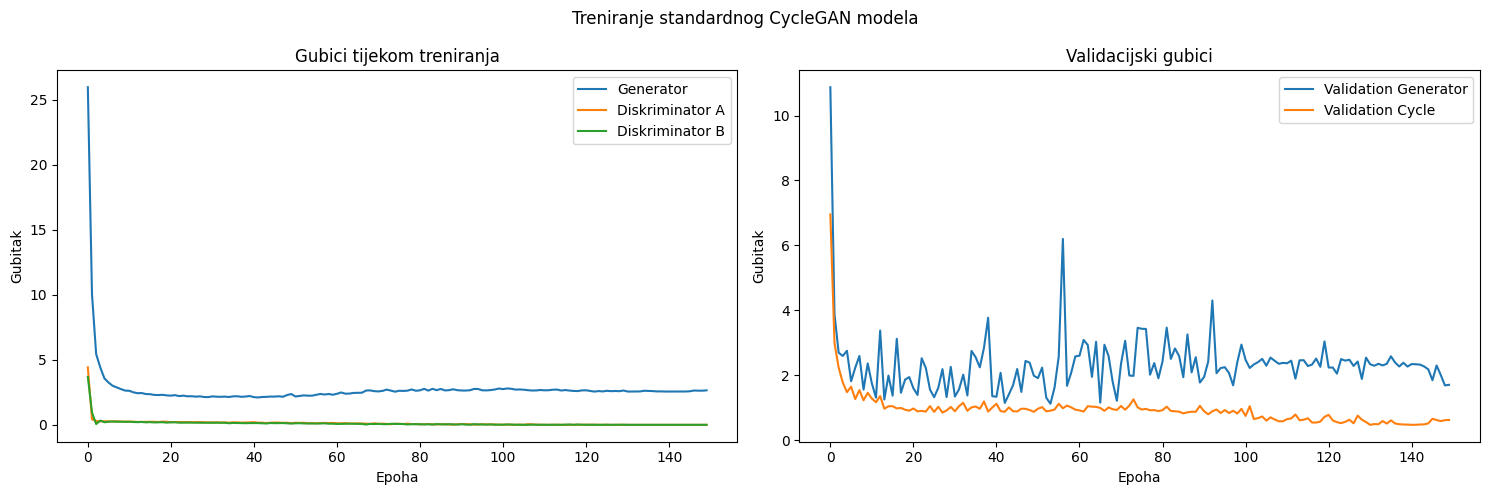

In [8]:
# Vizualizacija krivulja treniranja
plot_training_curves(train_history, "Treniranje standardnog CycleGAN modela")

In [9]:
test_model(G_AB=G_AB, G_BA=G_BA, test_dataloader=test_dataloader, config=config)

Evaluacija modela: 100%|██████████| 22/22 [00:02<00:00,  8.71it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.6899
  MSE: 0.009236
  PSNR: 20.41 dB

T2 -> T1 translacija:
  SSIM: 0.5263
  MSE: 0.014542
  PSNR: 18.40 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9161
  MSE: 0.001380
  PSNR: 28.63 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9019
  MSE: 0.001312
  PSNR: 28.96 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.5409
  MSE: 0.015188
  PSNR: 18.25 dB

T2 -> T1 translacija:
  SSIM: 0.4137
  MSE: 0.022264
  PSNR: 16.56 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.8683
  MSE: 0.002277
  PSNR: 26.46 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.8421
  MSE: 0.002166
  PSNR: 26.78 dB


Vizualizacija rezultata na test setu:


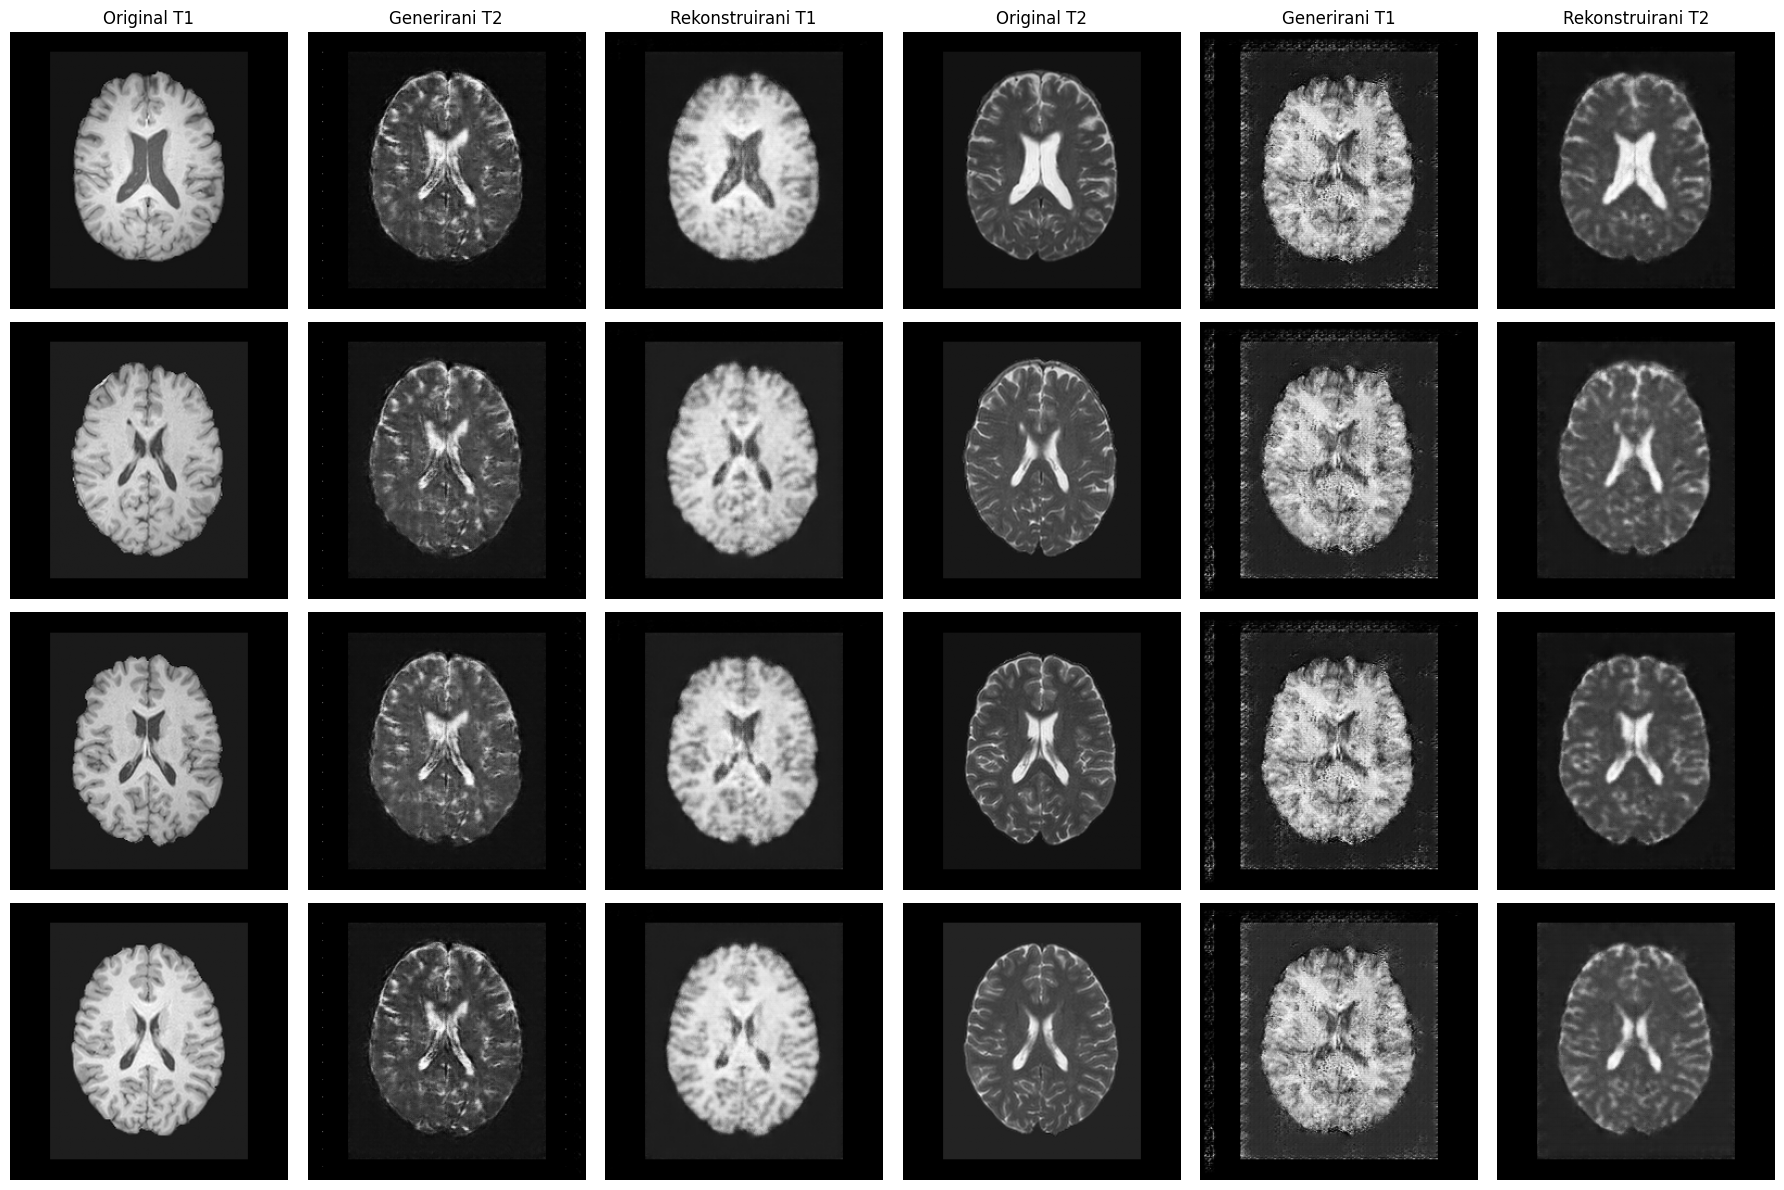

In [10]:
print("Vizualizacija rezultata na test setu:")
visualize_results(G_AB, G_BA, test_dataloader, num_samples=4, config=config)

In [12]:
best_G_AB = UNetGeneratorDeep(config.input_channels, config.output_channels, config.ngf).to(config.device)
best_G_BA = UNetGeneratorDeep(config.input_channels, config.output_channels, config.ngf).to(config.device)

# Putanje do najboljih modela
best_G_AB_path = f"{config.checkpoints_dir}/G_AB_best.pth"
best_G_BA_path = f"{config.checkpoints_dir}/G_BA_best.pth"
best_G_AB.load_state_dict(torch.load(best_G_AB_path, map_location=config.device))
best_G_BA.load_state_dict(torch.load(best_G_BA_path, map_location=config.device))

<All keys matched successfully>

In [13]:
print("Testiranje najboljih modela:")
test_model(best_G_AB, best_G_BA, test_dataloader, config)

Testiranje najboljih modela:


Evaluacija modela: 100%|██████████| 22/22 [00:02<00:00,  8.73it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.7428
  MSE: 0.006791
  PSNR: 21.94 dB

T2 -> T1 translacija:
  SSIM: 0.7395
  MSE: 0.006593
  PSNR: 21.92 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9490
  MSE: 0.000673
  PSNR: 31.81 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9295
  MSE: 0.000869
  PSNR: 30.73 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.5850
  MSE: 0.011217
  PSNR: 19.76 dB

T2 -> T1 translacija:
  SSIM: 0.5778
  MSE: 0.010890
  PSNR: 19.74 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9157
  MSE: 0.001111
  PSNR: 29.63 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.8837
  MSE: 0.001436
  PSNR: 28.55 dB


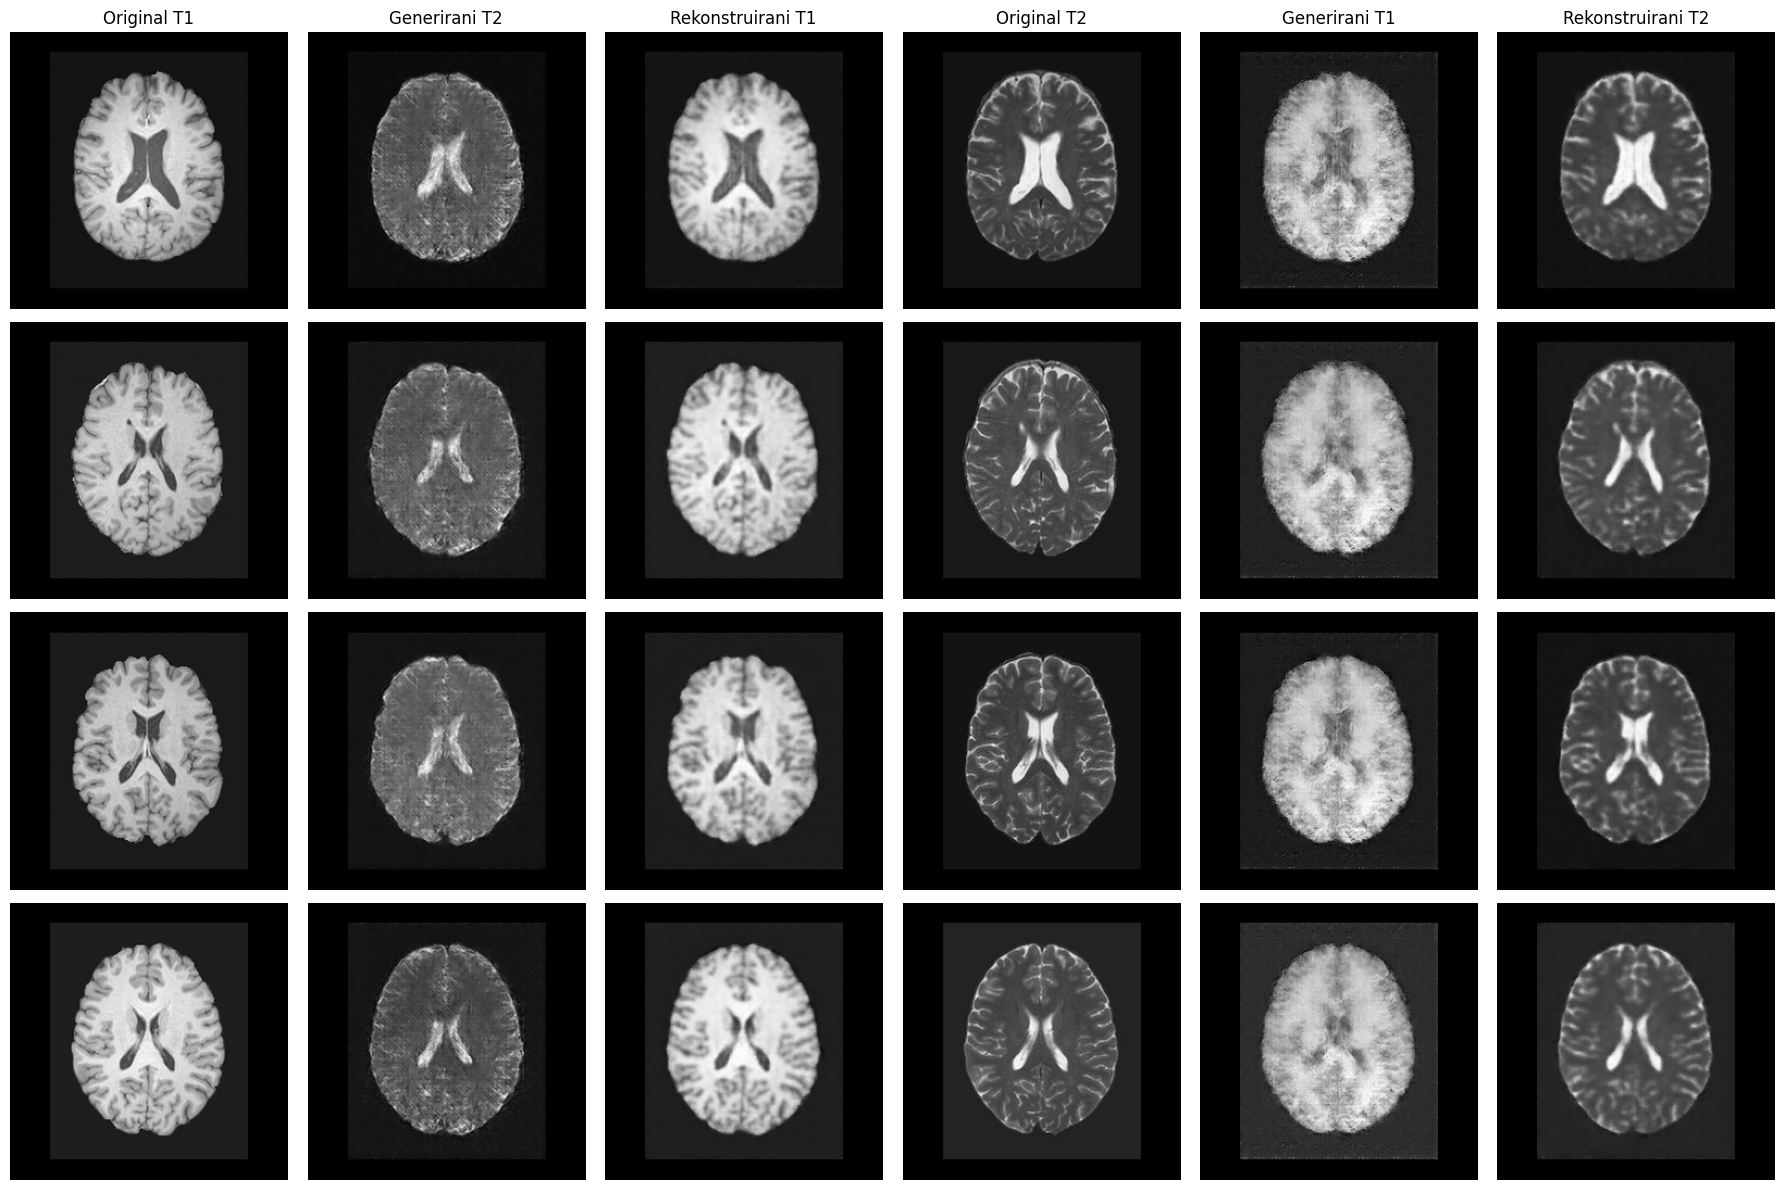

In [14]:
visualize_results(
    best_G_AB, best_G_BA, test_dataloader, num_samples=4, config=config
)